# ML-Agents: Banana Collector 
Double DQN

## Installation

In [ ]:
!git clone https://github.com/Unity-Technologies/ml-agents.git
!git -C ml-agents checkout 0.4.0b

!sudo pip3 install ml-agents/python/.

!pip install grpcio
!pip install seaborn
!pip install tqdm 

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux_NoVis.zip
!unzip Banana_Linux_NoVis.zip
!mv Banana_Linux_NoVis/ data/
!rm Banana_Linux_NoVis.zip

## Setup

In [1]:
import sys 
sys.path.append("ml-agents/python")
import numpy as np
from unityagents import UnityEnvironment
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
from IPython.display import FileLink, FileLinks

%load_ext autoreload
%autoreload 2
%matplotlib inline 

#from badaii.rl.agents.double_dqn import Agent
from badaii import helpers

## Environment

In [2]:
env = UnityEnvironment(file_name="data/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

## Helpers

In [4]:
def reset_env(env, brain_name):
    env_info = env.reset(train_mode=True)[brain_name]
    return env_info.vector_observations[0]

In [5]:
def step_env(env, action, brain_name):
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0] 
    done = env_info.local_done[0]  
    return (next_state, reward, done)

In [6]:
def init_replay_memory(agent, env, action_size, brain_name, size=50000):
    state = reset_env(env, brain_name)
    it = 0
    while it < size:
        action = np.random.randint(action_size)
        next_state, reward, done = step_env(env,action,brain_name)
        agent.step(state, action, reward, next_state, done, train=False)
        
        it+=1 
        if done:
            state = reset_env(env, brain_name)
        else:
            state = next_state

In [7]:
def train(agent, scores, env, brain_name, episodes, steps, replay_start_size, 
          inital_eps, final_eps, final_exp_ep,
          print_every=10, out_file='model_v1.ckpt'):
    #init_replay_memory(agent, env, replay_start_size)
    
    eps = initial_eps
    last_saved = 0 
    it = 0

    with tnrange(episodes) as t: 
        for ep_i in t: 
            state = reset_env(env, brain_name)
            score = 0
            for step_i in range(steps):
                action = agent.act(state, epsilon=eps)
                next_state, reward, done = step_env(env,action,brain_name)
                score += reward
                agent.step(state, action, reward, next_state, done)
                it += 1 
                state = next_state
                if done:
                    break
                
            eps = max(final_eps,initial_eps-(initial_eps-final_eps)/final_exp_ep*ep_i) 
            scores.add(score)
        
            if (ep_i+1) % print_every == 0:
                t.set_postfix(epsilon=eps, score=scores.last)
        
            if scores.last >= 13.0 and scores.last > last_saved:
                last_saved = scores.last
                print('Saving...')
                agent.save(out_file)

In [8]:
def hyper_search(scores, env, brain_name, 
                 lrates, 
                 final_exp_eps, 
                 taus, 
                 final_epsilons, 
                 gammas,
                 episodes=500, 
                 iterations=10):
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state = env_info.vector_observations[0]
    state_size = len(state)
    
    for it in range(iterations):
        lrate = lrates[np.random.randint(len(lrates))]
        final_exp_ep = final_exp_eps[np.random.randint(len(final_exp_eps))]
        tau = taus[np.random.randint(len(taus))] 
        final_eps = final_epsilons[np.random.randint(len(final_epsilons))] 
        gamma = gammas[np.random.randint(len(gammas))] 
        
        agent = Agent(
            state_size, 
            action_size, 
            seed=0, 
            replay_size=replay_size,
            tau = tau,
            lrate = lrate, 
            gamma = gamma
        )
        
        score = helpers.MovingResult(100, params = agent.params, name='score')
        score.params.add('final_exp_ep', final_exp_ep) 
        score.params.add('final_eps', final_eps)
        scores.append(score)
        
        print(f'-- Iteration {it+1}/{iterations} --')
        print(f'{score.params}')
        
        train(
            agent, 
            score, 
            env, 
            brain_name,
            episodes, 
            steps, 
            replay_start_size, 
            initial_eps, final_eps, 
            final_exp_ep
        )

In [9]:
def plot_scores(scores):
    plt.figure(figsize=(10,5), dpi=80)
    
    for i in range(len(scores)):
        print(f'Test #{i+1}: {scores[i].params}')
        x_moving, y_moving = zip(*scores[i].buffer_moving)
        plt.plot(list(x_moving), list(y_moving), label=f'Test #{i+1}')
        
    plt.legend()
    plt.xlabel('Episode #')
    plt.ylabel(f'Moving Score (100)')
    plt.show()

In [10]:
def calculate_score(env, brain_name, agent):
    scores = np.zeros(100)
    for ep_i in range(scores.shape[0]):
        state = reset_env(env, brain_name)
        score = 0
        while True:
            action = agent.act(state)
            next_state, reward, done = step_env(env,action,brain_name)
            score += reward
            state = next_state
            if done: 
                scores[ep_i] = score
                break    
    return scores.mean()

## Agent

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

from badaii.rl.agents.replay_buffer import ReplayBuffer
from badaii.moving_result import MovingResult

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, layers, seed=None):
        super(QNetwork, self).__init__()
        torch.manual_seed(seed)
        ls = [nn.Linear(state_size, layers[0])]
        ls.extend([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        ls.append(nn.Linear(layers[-1], action_size))
        
        self.layers = nn.ModuleList(ls)
        self.bns = nn.ModuleList([nn.BatchNorm1d(l) for l in layers])
        
    def forward(self, x):
        for i, l in enumerate(self.layers[:-1]):
            x = self.bns[i](F.relu(l(x)))
        x = self.layers[-1](x)
        return x

class Agent():
    """Double DQN Agent with epsilon-greedy policy 
    
    Parameters
    ----------
    state_size: int 
        Size of the observation space
    action_size: int
        Number of discrete actions
    seed: int 
        Number for random seeding
    replay_size: int
        Size of the experience replay buffer
    batch_size: int
        Size of the batch used when learning
    gamma: float
        Discount rate
    lrate: int or float
        Learning rate 
    tau: float
        Soft target update rate
    """
    def __init__(self, state_size=None, action_size=None, seed=None,
                 replay_size = 100000, batch_size=64, 
                 gamma=0.99, lrate=5e-4, tau=0.001, update_every = 4, 
                 hidden_layers = [250, 500, 250],
                 restore=None):

        if restore is not None:
            checkpoint = torch.load(restore, map_location={'cuda:0': 'cpu'})

        self.seed = seed if not restore else checkpoint['seed']
        self.action_size = action_size if not restore else checkpoint['action_size']
        self.state_size = state_size if not restore else checkpoint['state_size']
        self.replay_size = replay_size if not restore else checkpoint['replay_size']
        self.batch_size = batch_size if not restore else checkpoint['batch_size']
        self.gamma = gamma if not restore else checkpoint['gamma']
        self.lrate = lrate if not restore else checkpoint['lrate']
        self.tau = tau if not restore else checkpoint['tau']
        self.update_every = update_every if not restore else checkpoint['update_every']
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.hidden_layers = hidden_layers if not restore else checkpoint['hidden_layers']
        
        self.q_network = QNetwork(
            self.state_size, 
            self.action_size, 
            self.hidden_layers, 
            self.seed
        ).to(self.device)

        self.q_network_target = QNetwork(
            self.state_size, 
            self.action_size, 
            self.hidden_layers, 
            self.seed
        ).to(self.device)
        
        if restore is not None:
            self.q_network.load_state_dict(checkpoint['state_dict'])
            self.q_network_target.load_state_dict(checkpoint['state_dict'])

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lrate)
        
        self.reset()
        
    def save(self, filename):
        checkpoint = self.params
        checkpoint['state_dict'] = self.q_network.state_dict()
        torch.save(checkpoint, filename)
        
    def reset(self):
        self.it = 0
        self.memory = ReplayBuffer(
            self.action_size, self.replay_size, 
            self.update_every * self.batch_size, 
            self.seed, self.device
        )
        self.losses = MovingResult(100, name='loss', save_raw=False)
    
    def step(self, state, action, reward, next_state, done, train=True):
        self.memory.add(state, action, reward, next_state, done)
        self.it += 1 
        if train and self.it % self.update_every and len(self.memory) > self.memory.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)
    
    def act(self, state, epsilon=0.):
        """ Epsilon-Greedy policy
        
        """
        probs = epsilon * np.ones(self.action_size) / self.action_size
        state = torch.from_numpy(state).float().to(self.device)
        
        self.q_network.eval()
        with torch.no_grad():
            probs[np.argmax(self.q_network(state.reshape(1,-1)).cpu().numpy())] += 1-epsilon
        self.q_network.train()
        
        return np.random.choice(np.arange(self.action_size), p=probs)
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        # argmax_a Q^(next_state,a, w)
        with torch.no_grad():
            _ , best_actions = self.q_network(next_states).max(dim=1)
            # y^ = td_target
            # y^ = reward + gamma * Q^(next_state,argmax_a(next_state,a, w), w-), episode not terminal
            # y^ = reward, episode terminal
            td_targets = rewards + self.gamma * torch.gather(self.q_network_target(next_states),1,best_actions.view(-1,1))
            for i in range(self.memory.batch_size):
                if dones[i].item() == 1.0:
                    td_targets[i] = rewards[i]   
        
        # delta = y^-Q
        # clamp btwn -1..1
        delta = torch.clamp(td_targets-torch.gather(self.q_network(states),1,actions), -1., 1.)
        # loss = sum (y^-Q)^2
        loss = torch.sum(torch.pow(delta,2))
        self.losses.add(loss.item()/self.memory.batch_size)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update()
            
    def soft_update(self):
        """Soft update of target network
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        for target_param, param in zip(self.q_network_target.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau*param.data+(1-self.tau)*target_param.data)
            
    @property
    def params(self):
        params = {
            'state_size': self.state_size,
            'action_size': self.action_size,
            'seed': self.seed,
            'replay_size': self.replay_size,
            'batch_size': self.batch_size,
            'gamma': self.gamma, 
            'lrate': self.lrate,
            'tau': self.tau,
            'update_every': self.update_every,
            'hidden_layers': self.hidden_layers
        }
        return params
    
    @property 
    def trainable_params(self):
        return sum([np.prod(p.size()) for p in self.q_network.parameters()])

## Train

In [12]:
final_exp_ep = 500

# 1.0 -> 0.1
initial_eps = 1.0
final_eps = 0.01 

episodes = 1000
steps = 2000
replay_start_size = 5000
replay_size = 100000
tau = 0.05 
lrate = 5.0e-5
update_every = 4
batch_size = 32
hidden_layers = [100, 200, 100]

print_every = 10

In [ ]:
agent = Agent(
    state_size, 
    action_size, 
    seed=0, 
    replay_size=replay_size,
    tau = tau,
    lrate = lrate,
    batch_size = batch_size,
    update_every = update_every,
    hidden_layers = hidden_layers
)

scores = helpers.MovingResult(100, name='score', save_raw=False)

scores_agent = train(
    agent, 
    scores, 
    env, 
    brain_name,
    episodes, 
    steps, 
    replay_start_size, 
    initial_eps, final_eps, 
    final_exp_ep,
    out_file='model_v1.ckpt',
    print_every = print_every
)

In [16]:
FileLink('model_v1.ckpt')

/home/ubuntu/banana-collector/model_v1.ckpt

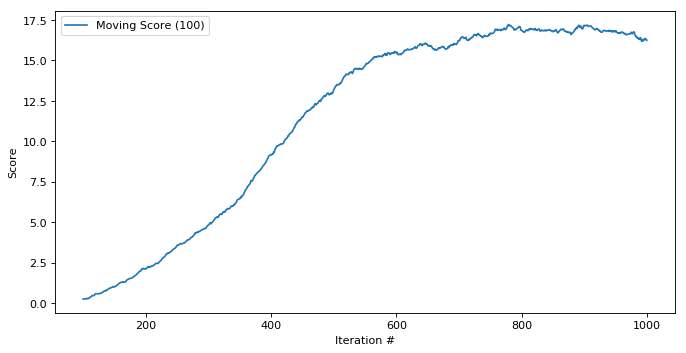

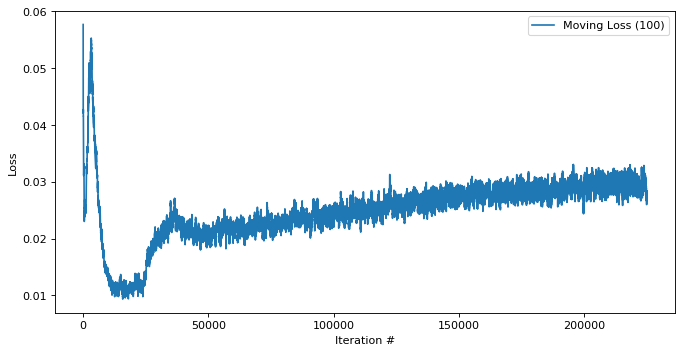

In [14]:
scores.plot()
agent.losses.plot()

## Hyperparameters Search

In [ ]:
scores = []

hyper_search(
    scores,
    env, brain_name, 
    final_exp_eps = [250],
    taus=[0.05],
    lrates = [0.1e-4, 0.5e-4, 1.0e-4],
    final_epsilons = [0.1, 0.01],
    gammas = [0.9, 0.95, 0.99],
    iterations = 25
)